In [ ]:
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths


In [ ]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from datetime import datetime

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
logins_data = pd.read_csv('/content/summit_login_v2.csv')
#logins_data = pd.read_csv('/content/summit_login_v2_1000.csv')
logins_data

,idx,node,date,hour,users,running_procs,cpu_load_1_min,cpu_load_5_min,cpu_load_15_min,mem_total,mem_avail,mem_used,unaliased_ls_time,color_ls_time,running_jobs,total_jobs,time_to_create_1G,disk_util,wo_ho_we,datetime
0,1,login1,4/1/20,0,42,437,2.32,3.35,6.64,601183424,495599232,105584192,0.003,0.003,57,449,23.813999,12,0,4/1/20 0:00
1,2,login1,4/1/20,1,42,388,4.30,3.52,3.99,601183424,493543168,107640256,0.003,0.003,57,460,23.816999,13,0,4/1/20 1:00
2,3,login1,4/1/20,2,38,381,4.83,8.77,7.36,601183424,487480512,113702912,0.003,0.003,58,455,24.136000,15,0,4/1/20 2:00
3,4,login1,4/1/20,3,33,391,3.26,3.89,5.43,601183424,498246720,102936704,0.003,0.003,56,436,23.910999,12,0,4/1/20 3:00
4,5,login1,4/1/20,4,31,369,4.24,4.38,4.50,601183424,497897024,103286400,0.003,0.003,45,417,23.698000,12,0,4/1/20 4:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82523,82524,login5,9/30/21,19,74,398,4.02,2.81,2.62,601136896,309410944,291725952,0.004,0.004,143,1317,3.944000,8,0,9/30/21 19:00
82524,82525,login5,9/30/21,20,73,390,1.44,2.50,2.76,601136896,309521024,291615872,0.004,0.004,137,1220,3.947000,8,0,9/30/21 20:00
82525,82526,login5,9/30/21,21,64,397,0.44,0.33,0.49,601136896,310103872,291033024,0.004,0.004,135,1160,3.945000,8,0,9/30/21 21:00
82526,82527,login5,9/30/21,22,61,393,3.96,2.52,2.12,601136896,310559232,290577664,0.004,0.004,129,1140,3.955000,8,0,9/30/21 22:00


In [ ]:
logins_data["datetime_date"] = pd.to_datetime(logins_data['datetime'], format='%m/%d/%y %H:%M')

# add time index
logins_data["time_idx"] = logins_data["datetime_date"].dt.year * 12 + logins_data["datetime_date"].dt.month
logins_data["time_idx"] -= logins_data["time_idx"].min()

# add additional features
logins_data["month"] = logins_data.datetime_date.dt.month.astype(str).astype("category")  # categories have to be strings
logins_data["log_load15"] = np.log(logins_data.cpu_load_15_min + 1e-8)
logins_data["avg_load15_by_login"] = logins_data.groupby(["time_idx", "node"], observed=True).cpu_load_15_min.transform("mean")
logins_data["avg_users_by_login"] = logins_data.groupby(["time_idx", "node"], observed=True).users.transform("mean")
logins_data["avg_running_procs_by_login"] = logins_data.groupby(["time_idx", "node"], observed=True).running_procs.transform("mean")

logins_data

,idx,node,date,hour,users,running_procs,cpu_load_1_min,cpu_load_5_min,cpu_load_15_min,mem_total,...,disk_util,wo_ho_we,datetime,datetime_date,time_idx,month,log_load15,avg_load15_by_login,avg_users_by_login,avg_running_procs_by_login
0,1,login1,4/1/20,0,42,437,2.32,3.35,6.64,601183424,...,12,0,4/1/20 0:00,2020-04-01 00:00:00,3,4,1.893112,13.110462,43.381818,524.485315
1,2,login1,4/1/20,1,42,388,4.30,3.52,3.99,601183424,...,13,0,4/1/20 1:00,2020-04-01 01:00:00,3,4,1.383791,13.110462,43.381818,524.485315
2,3,login1,4/1/20,2,38,381,4.83,8.77,7.36,601183424,...,15,0,4/1/20 2:00,2020-04-01 02:00:00,3,4,1.996060,13.110462,43.381818,524.485315
3,4,login1,4/1/20,3,33,391,3.26,3.89,5.43,601183424,...,12,0,4/1/20 3:00,2020-04-01 03:00:00,3,4,1.691939,13.110462,43.381818,524.485315
4,5,login1,4/1/20,4,31,369,4.24,4.38,4.50,601183424,...,12,0,4/1/20 4:00,2020-04-01 04:00:00,3,4,1.504077,13.110462,43.381818,524.485315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82523,82524,login5,9/30/21,19,74,398,4.02,2.81,2.62,601136896,...,8,0,9/30/21 19:00,2021-09-30 19:00:00,20,9,0.963174,1.361275,55.858169,373.901257
82524,82525,login5,9/30/21,20,73,390,1.44,2.50,2.76,601136896,...,8,0,9/30/21 20:00,2021-09-30 20:00:00,20,9,1.015231,1.361275,55.858169,373.901257
82525,82526,login5,9/30/21,21,64,397,0.44,0.33,0.49,601136896,...,8,0,9/30/21 21:00,2021-09-30 21:00:00,20,9,-0.713350,1.361275,55.858169,373.901257
82526,82527,login5,9/30/21,22,61,393,3.96,2.52,2.12,601136896,...,8,0,9/30/21 22:00,2021-09-30 22:00:00,20,9,0.751416,1.361275,55.858169,373.901257


In [ ]:
logins_data.describe()

,idx,hour,users,running_procs,cpu_load_1_min,cpu_load_5_min,cpu_load_15_min,mem_total,mem_avail,mem_used,...,running_jobs,total_jobs,time_to_create_1G,disk_util,wo_ho_we,time_idx,log_load15,avg_load15_by_login,avg_users_by_login,avg_running_procs_by_login
count,82528.000000,82528.000000,82528.000000,82528.000000,82528.000000,82528.000000,82528.000000,8.252800e+04,8.252800e+04,8.252800e+04,...,82528.000000,82528.000000,82468.000000,82528.000000,82528.000000,82528.000000,82528.000000,82528.000000,82528.000000,82528.000000
mean,41264.500000,11.499588,61.342756,492.665253,9.937587,9.920196,9.893319,6.011754e+08,3.481103e+08,2.530651e+08,...,83.551958,835.011693,14.711155,11.718823,0.610496,11.458523,0.899096,9.893319,61.342756,492.665253
std,23823.925845,6.935760,24.878454,341.788867,35.673488,35.406624,34.786367,1.757326e+04,7.494218e+07,7.494180e+07,...,42.759771,305.914018,220.003781,5.207566,0.904683,6.868280,1.825234,25.052501,14.827483,242.658170
min,1.000000,0.000000,1.000000,16.000000,0.000000,0.000000,0.000000,6.011369e+08,5.526144e+06,4.193350e+07,...,0.000000,4.000000,0.008000,5.000000,0.000000,0.000000,-18.420681,1.361275,18.779917,240.581989
25%,20632.750000,5.000000,43.000000,289.000000,0.870000,1.030000,1.120000,6.011834e+08,2.956277e+08,2.134746e+08,...,54.000000,620.000000,3.866750,8.000000,0.000000,6.000000,0.113329,2.752685,50.805556,337.626420
50%,41264.500000,12.000000,59.000000,403.000000,2.310000,2.550000,2.740000,6.011834e+08,3.311228e+08,2.700565e+08,...,78.000000,795.000000,3.981000,10.000000,0.000000,11.000000,1.007958,3.899877,59.577957,429.794979
75%,61896.250000,18.000000,77.000000,591.000000,6.240000,6.310000,6.280000,6.011834e+08,3.877051e+08,3.055460e+08,...,106.000000,1011.000000,23.809000,14.000000,2.000000,17.000000,1.837370,6.126259,72.636207,562.798639
max,82528.000000,23.000000,166.000000,4789.000000,2219.370117,2242.659912,1529.300049,6.011834e+08,5.592499e+08,5.956573e+08,...,464.000000,5162.000000,56618.406250,39.000000,2.000000,23.000000,7.332565,224.221393,92.681073,2063.516084


In [ ]:
max_prediction_length = 8
max_encoder_length = 24
training_cutoff = logins_data["time_idx"].max() - max_prediction_length
print(training_cutoff)
#print(logins_data[lambda x: x.time_idx <= training_cutoff])

logins_training = TimeSeriesDataSet(
    logins_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="cpu_load_15_min",
    group_ids=["node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["node"],
    static_reals=["mem_total"],
    time_varying_known_categoricals=["month"],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    variable_groups=[],
    time_varying_known_reals=["time_idx","users","running_procs"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "cpu_load_15_min",
        "log_load15",
        "avg_load15_by_login",
        #"avg_users_by_login",
        #"avg_running_procs_by_login",
        #"running_procs",
        #"users",
        #"mem_used",
    ],
    target_normalizer=GroupNormalizer(
        groups=["node"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
logins_validation = TimeSeriesDataSet.from_dataset(logins_training, logins_data, predict=True, stop_randomization=True)

# create dataloaders for model
logins_batch_size = 32  # set this between 32 to 128
logins_train_dataloader = logins_training.to_dataloader(train=True, batch_size=logins_batch_size, num_workers=0)
logins_val_dataloader = logins_validation.to_dataloader(train=False, batch_size=logins_batch_size * 10, num_workers=0)

15


In [ ]:
# Login Data
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(logins_val_dataloader)])
baseline_predictions = Baseline().predict(logins_val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.8222500085830688

In [ ]:
# Login Data
# configure network and trainer
pl.seed_everything(42)
logins_trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


logins_tft = TemporalFusionTransformer.from_dataset(
    logins_training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {logins_tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 23.7k


In [ ]:
# Login Data
# find optimal learning rate
logins_res = logins_trainer.tuner.lr_find(
    logins_tft,
    train_dataloaders=logins_train_dataloader,
    val_dataloaders=logins_val_dataloader,
    #max_lr=2.0,
    #min_lr=1e-3,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {logins_res.suggestion()}")
fig = logins_res.plot(show=True, suggest=True)
fig.show()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_9d3bc9c9-4719-48e0-8045-308d559ed26f.ckpt


suggested learning rate: 0.012284002568219973


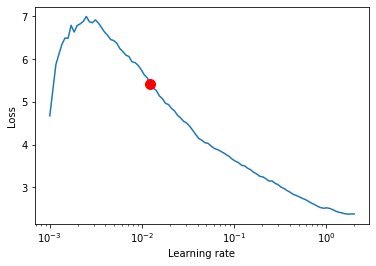

In [ ]:
# Login Data
# find optimal learning rate
logins_res = logins_trainer.tuner.lr_find(
    logins_tft,
    train_dataloaders=logins_train_dataloader,
    val_dataloaders=logins_val_dataloader,
    #max_lr=2.0,
    #min_lr=1e-3,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {logins_res.suggestion()}")
fig = logins_res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("./lightning_logs")  # logging results to a tensorboard

logins_trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


logins_tft = TemporalFusionTransformer.from_dataset(
    logins_training,
    learning_rate=0.012,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {logins_tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 23.7k


In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [ ]:
print(logins_val_dataloader.dataset.data)

{'reals': tensor([[ 7.0212e-02,  0.0000e+00, -8.7530e-01,  ..., -6.2494e-01,
         -9.4136e-01, -3.2106e-01],
        [ 7.0212e-02,  0.0000e+00, -8.7530e-01,  ..., -4.2283e-01,
         -1.5419e-01, -3.2106e-01],
        [ 7.0212e-02,  0.0000e+00, -8.7530e-01,  ..., -6.5950e-01,
         -1.3252e+00, -3.2106e-01],
        ...,
        [-1.0405e+04,  0.0000e+00, -8.1320e-01,  ..., -4.0011e-01,
         -5.2816e-01, -3.2983e-01],
        [-1.0405e+04,  0.0000e+00, -8.1320e-01,  ..., -4.1764e-01,
         -6.4514e-01, -3.2983e-01],
        [-1.0405e+04,  0.0000e+00, -8.1320e-01,  ..., -4.8072e-01,
         -1.5644e+00, -3.2983e-01]]), 'categoricals': tensor([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [4, 3],
        [4, 3],
        [4, 3]]), 'groups': tensor([[0],
        [0],
        [0],
        ...,
        [4],
        [4],
        [4]]), 'target': [tensor([0.6900, 2.6200, 0.3600,  ..., 1.3900, 1.1400, 0.2400])], 'weight': None, 'time': tensor([ 0,  0,  0,  ..., 2


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 92    
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: ignored

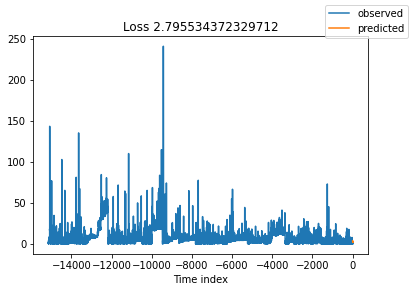

In [ ]:
#device=torch.device('cuda')

# fit network
logins_trainer.fit(
    logins_tft,
    train_dataloaders=logins_train_dataloader,
    val_dataloaders=logins_val_dataloader,
)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = logins_trainer.checkpoint_callback.best_model_path
best_model_path
#best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

''

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(logins_val_dataloader)])
predictions = best_tft.predict(logins_val_dataloader)
(actuals - predictions).abs().mean()

NameError: ignored

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(logins_val_dataloader, mode="raw", return_x=True)

NameError: ignored

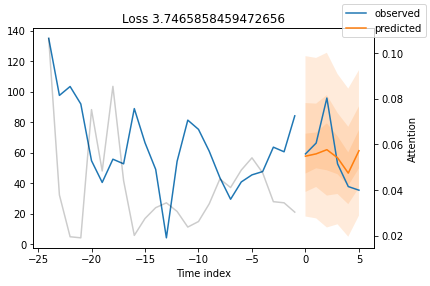

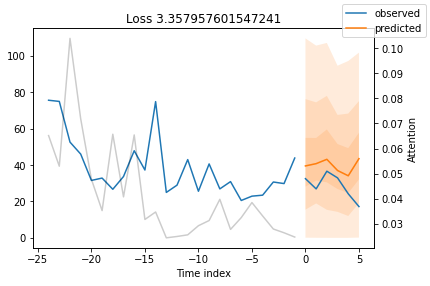

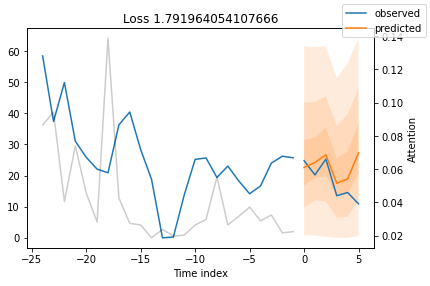

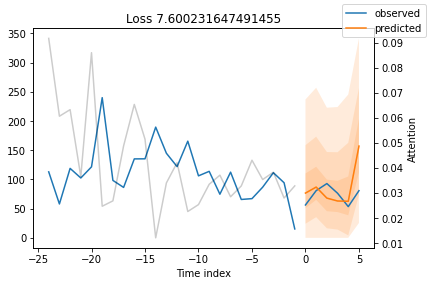

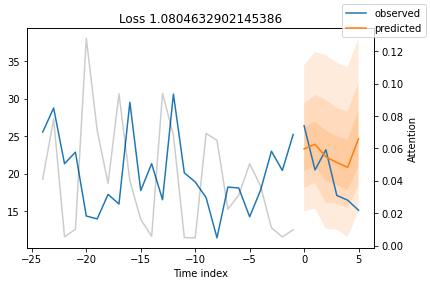

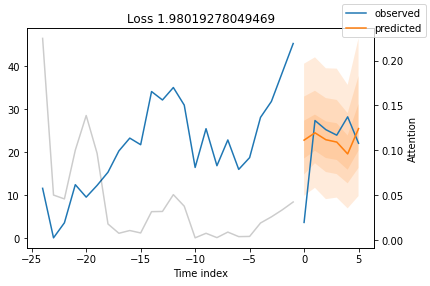

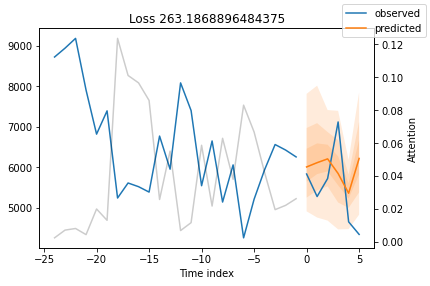

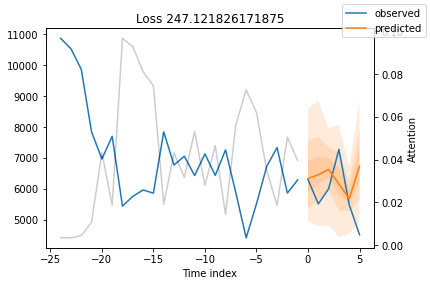

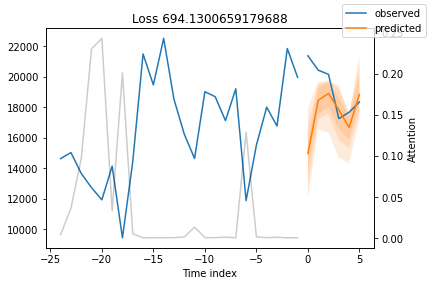

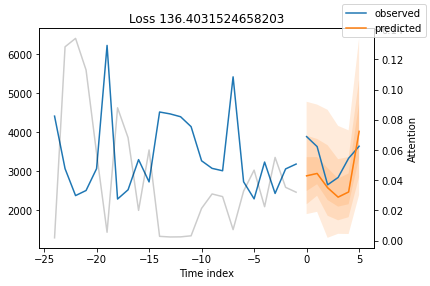

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

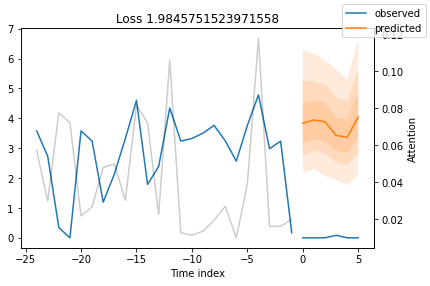

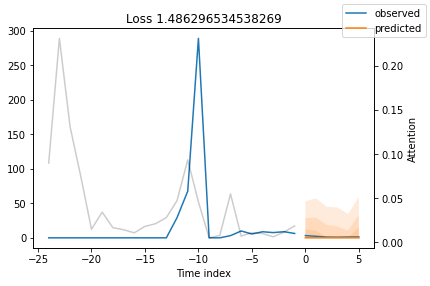

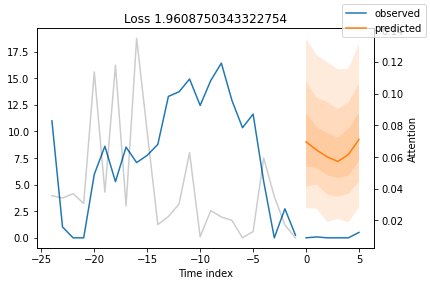

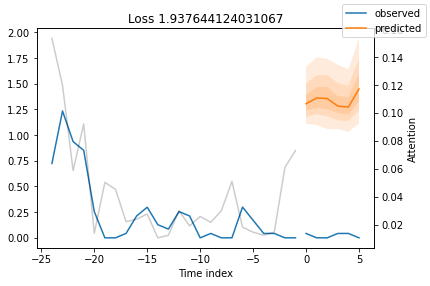

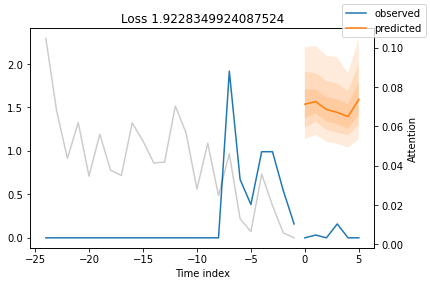

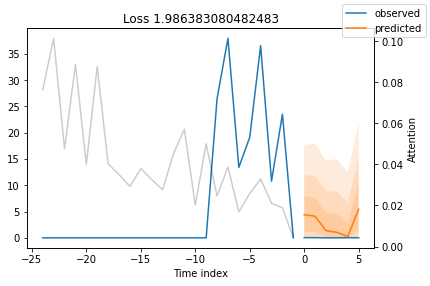

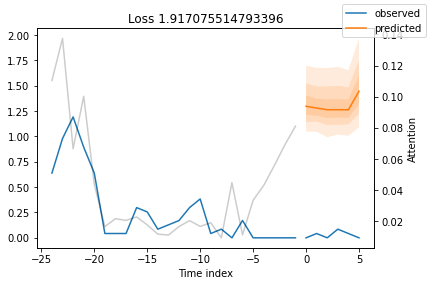

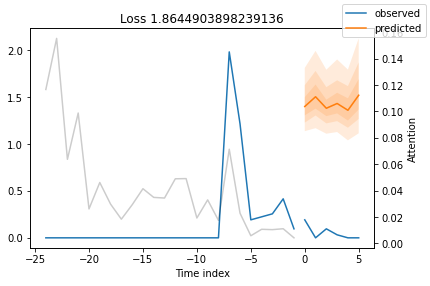

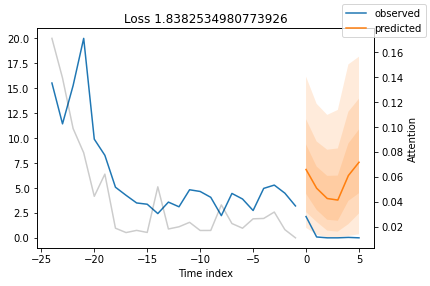

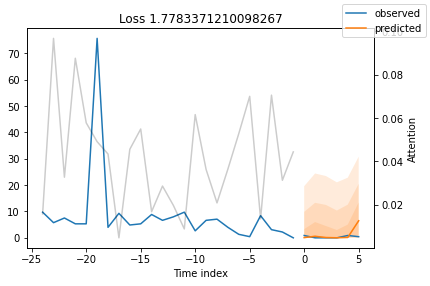

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

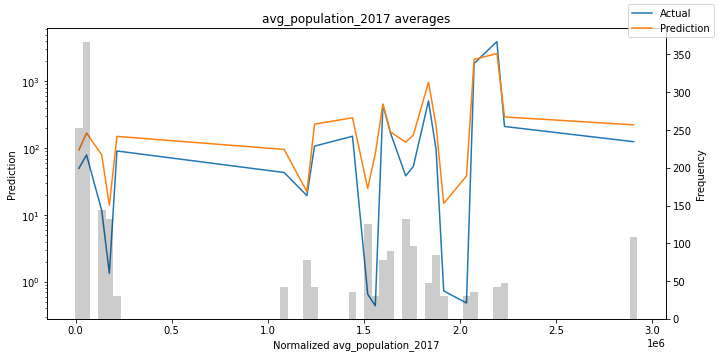

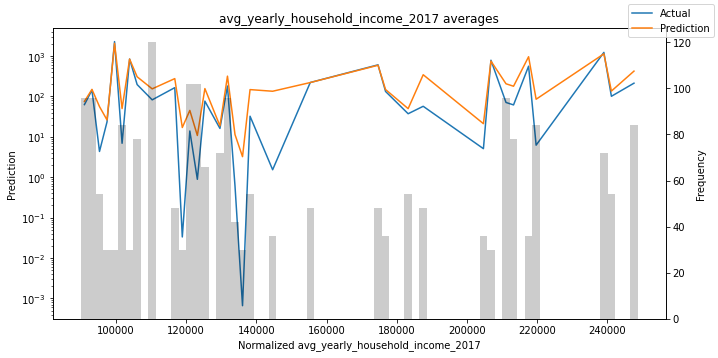

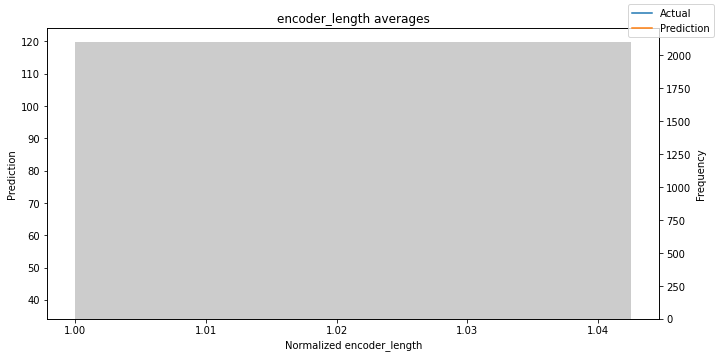

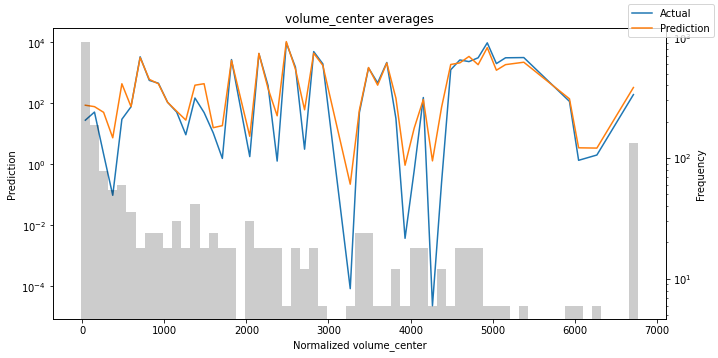

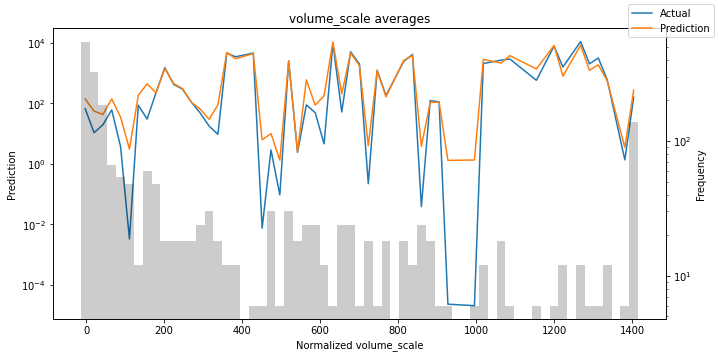

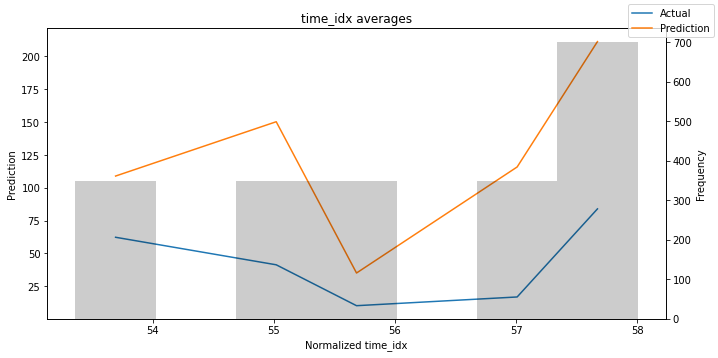

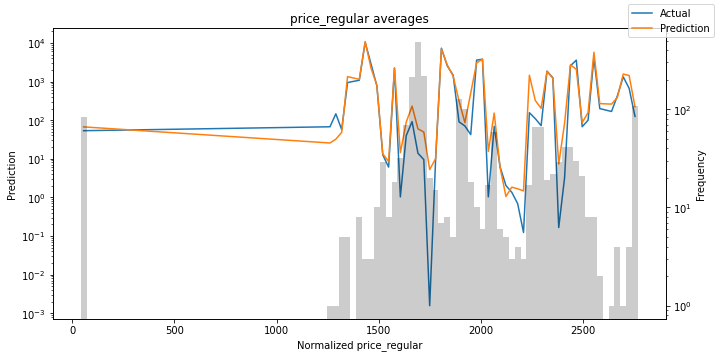

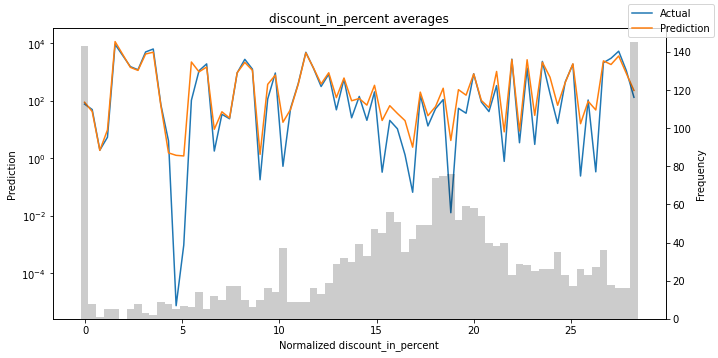

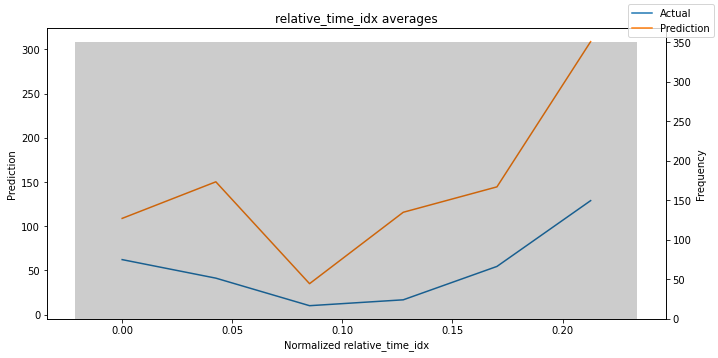

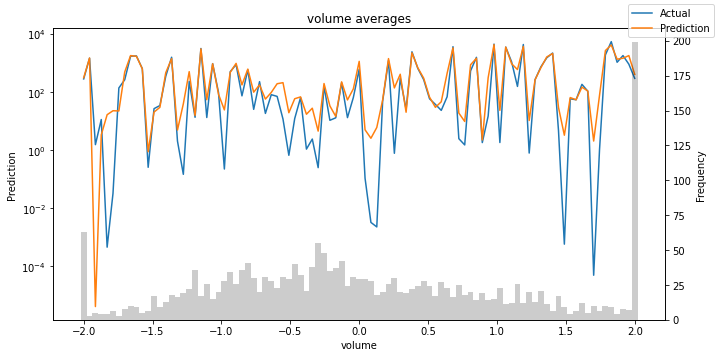

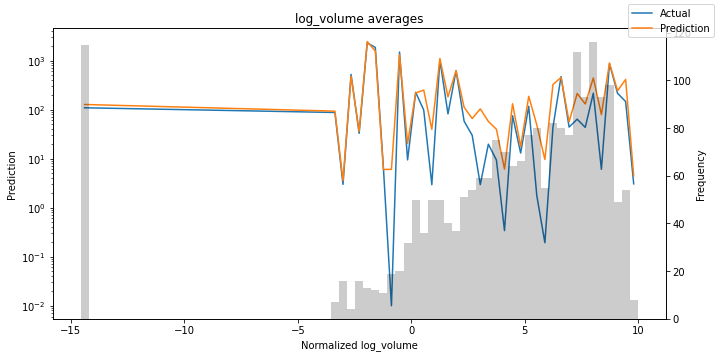

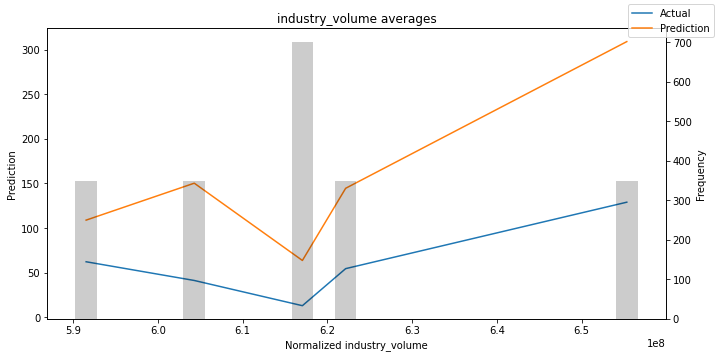

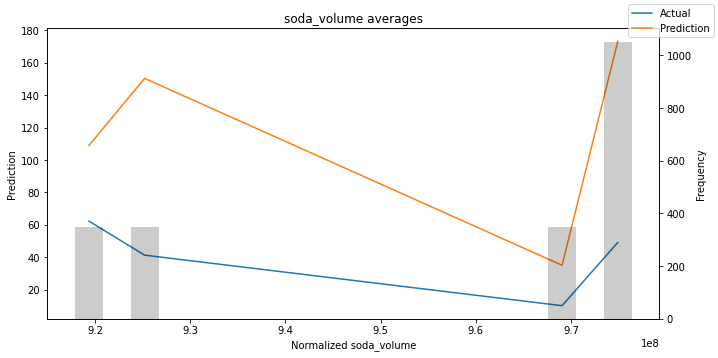

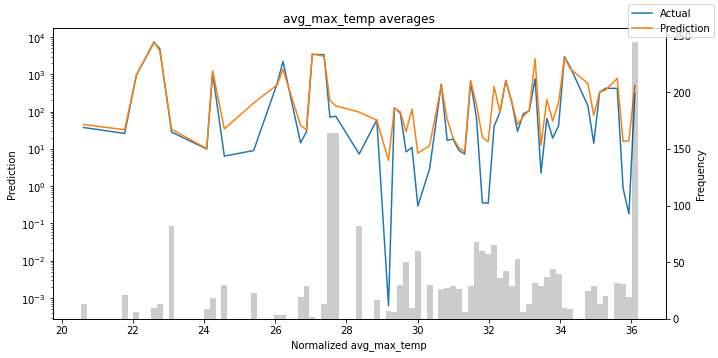

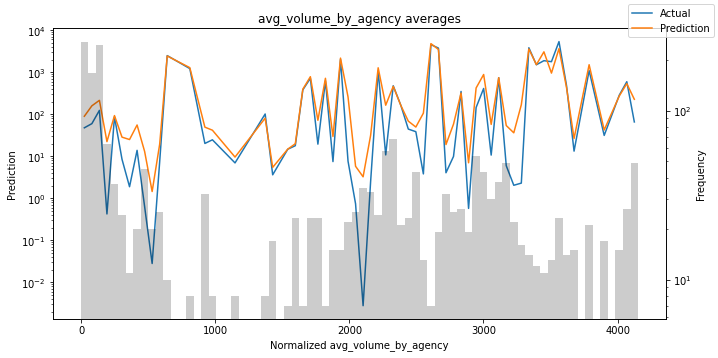

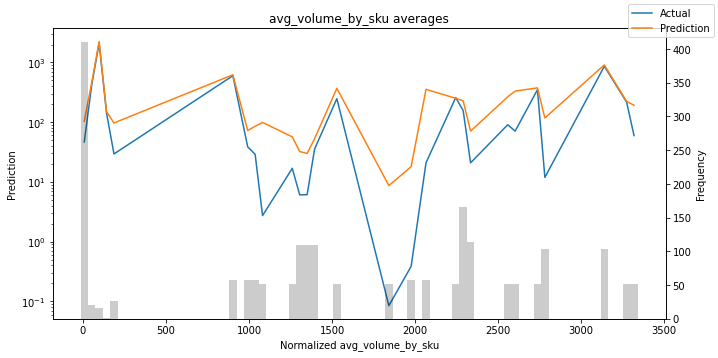

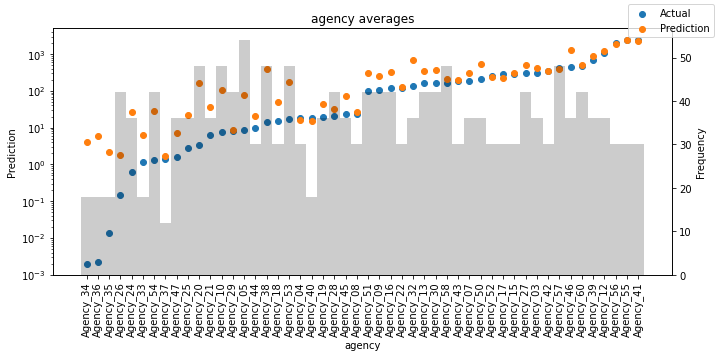

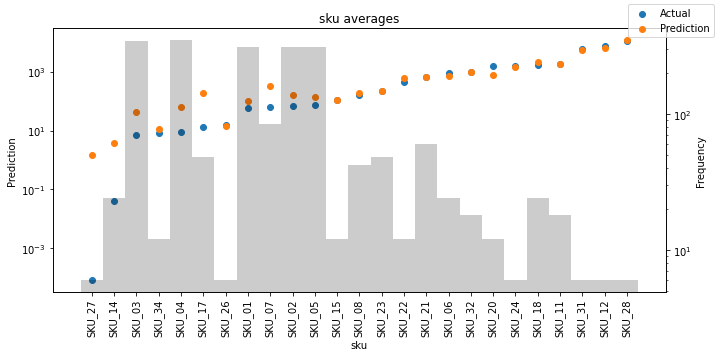

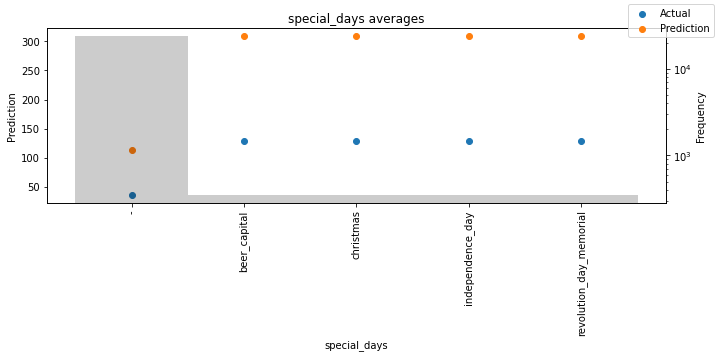

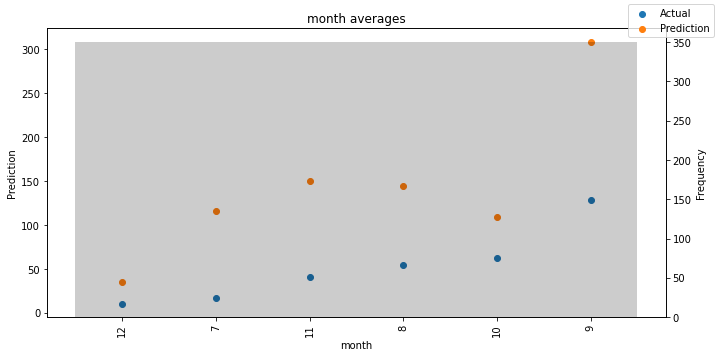

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 59.5318,  89.4705, 109.2831, 130.3951, 150.1106, 172.2764, 199.7754],
         [ 43.3031,  70.9150,  87.1569, 107.4877, 124.0277, 146.3486, 174.9895],
         [ 44.3636,  67.9043,  82.2875, 101.0942, 117.0433, 137.3260, 163.9954],
         [ 45.0829,  66.3781,  79.8109,  98.7805, 115.0419, 135.3624, 162.4352],
         [ 46.1260,  68.4102,  81.2984,  97.6671, 112.5956, 131.3144, 157.2382],
         [ 31.5968,  54.0252,  68.0447,  85.3242, 101.4166, 121.6936, 148.3604]]])

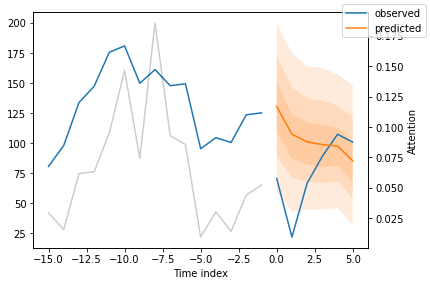

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

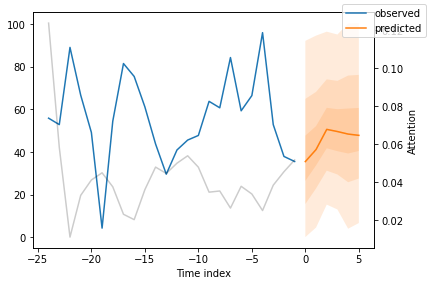

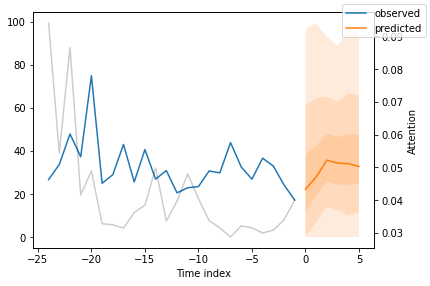

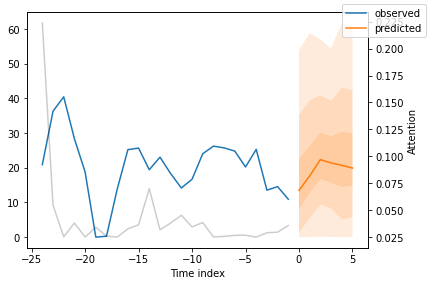

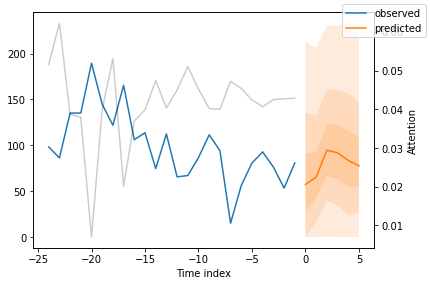

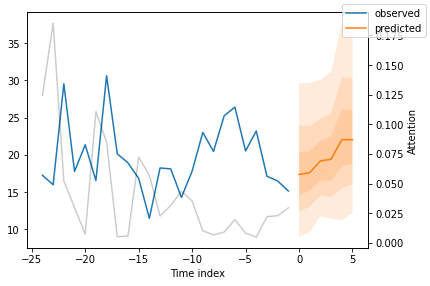

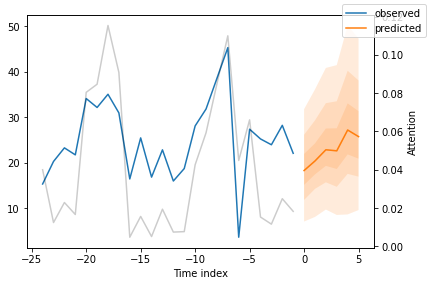

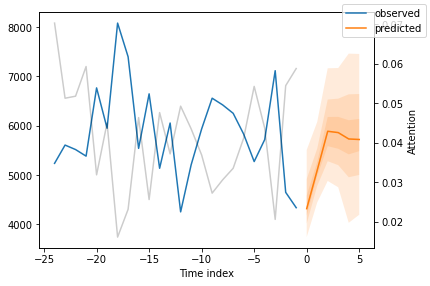

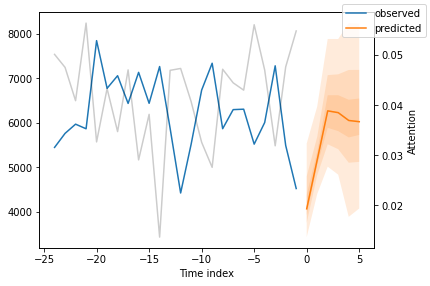

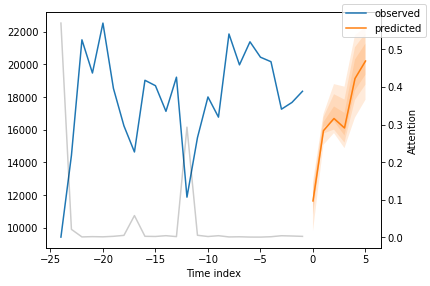

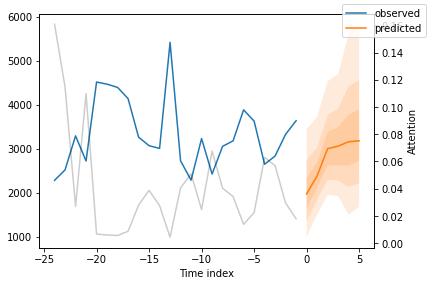

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>}

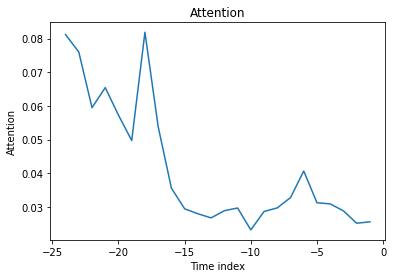

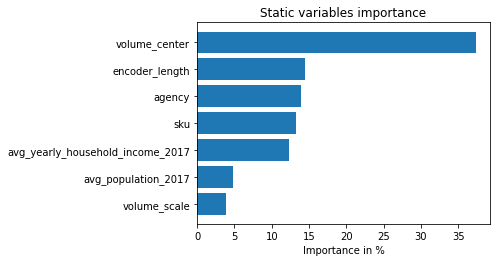

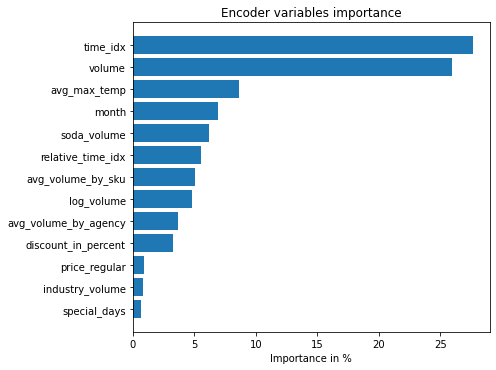

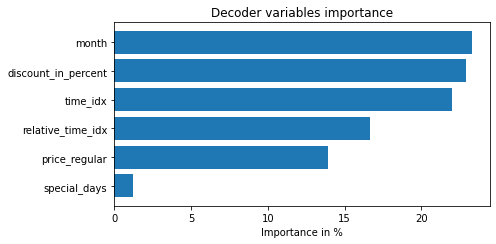

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

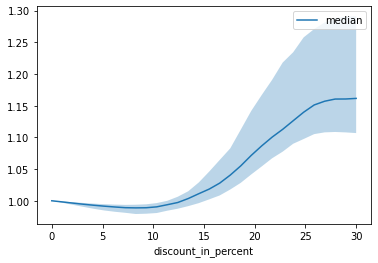

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);